In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.keras.backend.set_session(tf.Session(config=config))

In [0]:
import numpy as np
import keras
from keras_preprocessing import image
from PIL import Image
import cv2


def random_flip(img, mask, u=0.5):
    if np.random.random() < u:
        img = image.flip_axis(img, 1)
        mask = image.flip_axis(mask, 1)
    if np.random.random() < u:
        img = image.flip_axis(img, 0)
        mask = image.flip_axis(mask, 0)
    return img, mask

def random_rotate(img, mask, rotate_limit=(-20, 20), u=0.5):
    if np.random.random() < u:
        theta = np.random.uniform(rotate_limit[0], rotate_limit[1])
        img = image.apply_affine_transform(img, theta=theta)
        mask = image.apply_affine_transform(mask, theta=theta)
    return img, mask

def shift(x, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = hshift * h
    ty = wshift * w
    x = image.apply_affine_transform(x, ty=ty, tx=tx)
    return x

def random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.5):
    if np.random.random() < u:
        wshift = np.random.uniform(w_limit[0], w_limit[1])
        hshift = np.random.uniform(h_limit[0], h_limit[1])
        img = shift(img, wshift, hshift)
        mask = shift(mask, wshift, hshift)
    return img, mask

def random_zoom(img, mask, zoom_range=(0.8, 1), u=0.5):
    if np.random.random() < u:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
        img = image.apply_affine_transform(img, zx=zx, zy=zy)
        mask = image.apply_affine_transform(mask, zx=zx, zy=zy)
    return img, mask



def random_shear(img, mask, intensity_range=(-0.5, 0.5), u=0.5):
    if np.random.random() < u:
        sh = np.random.uniform(-intensity_range[0], intensity_range[1])
        img = image.apply_affine_transform(img, shear=sh)
        mask = image.apply_affine_transform(mask, shear=sh)
    return img, mask

def random_gray(img, u=0.5):
    if np.random.random() < u:
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = np.sum(img * coef, axis=2)
        img = np.dstack((gray, gray, gray))
    return img

def random_contrast(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = img * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        img = alpha * img + gray
        img = np.clip(img, 0., 1.)
    return img

def random_brightness(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        img = alpha * img
        img = np.clip(img, 0., 1.)
    return img

def random_saturation(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = img * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        img = alpha * img + (1. - alpha) * gray
        img = np.clip(img, 0., 1.)
    return img

def random_channel_shift(x, limit, channel_axis=2):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_ch + np.random.uniform(-limit, limit), min_x, max_x) for x_ch in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def random_crop(img, mask, u=0.1):
    if np.random.random() < u:
        w, h = img.shape[0], img.shape[1]
        offsetw = np.random.randint(w//2)
        offseth = np.random.randint(w//2)

        endw = np.random.randint(w // 2)+w // 2
        endh = np.random.randint(w // 2)+w // 2

        new_im = img[offsetw:offsetw + endw, offseth:offseth + endh, :]
        new_mask = mask[offsetw:offsetw + endw, offseth:offseth + endh, :]

        new_im, new_mask = cv2.resize(new_im, interpolation = cv2.INTER_LINEAR, dsize=(w, h)), \
               cv2.resize(new_mask, interpolation=cv2.INTER_LINEAR, dsize=(w, h))

        new_mask = new_mask[..., np.newaxis]
        return new_im, new_mask
    else:
        return img, mask


def random_augmentation(img, mask):
    img = random_brightness(img, limit=(-0.1, 0.1), u=0.05)
    img = random_contrast(img, limit=(-0.1, 0.1), u=0.05)
    img = random_saturation(img, limit=(-0.1, 0.1), u=0.05)
    img, mask = random_rotate(img, mask, rotate_limit=(-10, 10), u=0.05)
    img, mask = random_shear(img, mask, intensity_range=(-5, 5), u=0.05)
    img, mask = random_flip(img, mask, u=0.5)
    img, mask = random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.05)
    img, mask = random_zoom(img, mask, zoom_range=(0.9, 1.1), u=0.05)
    return img, mask

In [18]:
import argparse
from glob import glob

import numpy as np
from PIL import Image
from keras import backend as K
from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, MaxPooling2D , Activation , Multiply
from keras.layers import concatenate, Conv2D, Conv2DTranspose, Dropout, ReLU , BatchNormalization , Add
from keras.models import Model
from keras.optimizers import Adam
from numpy import random
import tensorflow as tf
#from aug_utils import random_augmentation
from random import randint


batch_size = 16
input_shape = (64, 64)


def custom_activation(x):
    return K.relu(x, alpha=0.0, max_value=1)


def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

smooth = 1.



def AttentionBlock(x,shortcut,i_filters):
    g1 = Conv2D(i_filters,kernel_size = 1)(shortcut) 
    g1 = BatchNormalization()(g1)
    x1 = Conv2D(i_filters,kernel_size = 1)(x) 
    x1 = BatchNormalization()(x1)

    g1_x1 = Add()([g1,x1])
    psi = Activation('relu')(g1_x1)
    psi = Conv2D(1,kernel_size = 1)(psi) 
    psi = BatchNormalization()(psi)
    psi = Activation('sigmoid')(psi)
    x = Multiply()([x,psi])
    return x



def get_unet(do=0.1, activation=ReLU):
    inputs = Input((None, None, 3))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(inputs)))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(pool1)))
    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(pool2)))
    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(pool3)))
    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(pool4)))
    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(conv5)))
    
    
    AttentionBlock(conv5,conv4,3)
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5),conv4], axis=3)       
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(up6)))
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv6)))

    AttentionBlock(conv6,conv3,3)
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(up7)))
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv7)))

    AttentionBlock(conv7,conv2,3)
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(up8)))
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv8)))
    
    AttentionBlock(conv8,conv1,3)
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(up9)))
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv9)))

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss=losses.binary_crossentropy, metrics=['accuracy'])


    return model


def read_input(path):
    x = np.array(Image.open(path))/255.
    return x


def read_gt(path):
    x = np.array(Image.open(path))/255.
    return x[..., np.newaxis]


def random_crop(img, mask, crop_size=input_shape[0]):
    imgheight= img.shape[0]
    imgwidth = img.shape[1]
    i = randint(0, imgheight-crop_size)
    j = randint(0, imgwidth-crop_size)

    return img[i:(i+crop_size), j:(j+crop_size), :], mask[i:(i+crop_size), j:(j+crop_size)]


def gen(data, au=False):
    while True:
        repeat = 4
        index= random.choice(list(range(len(data))), batch_size//repeat)
        index = list(map(int, index))
        list_images_base = [read_input(data[i][0]) for i in index]
        list_gt_base = [read_gt(data[i][1]) for i in index]

        list_images = []
        list_gt = []

        for image, gt in zip(list_images_base, list_gt_base):

            for _ in range(repeat):
                image_, gt_ = random_crop(image.copy(), gt.copy())
                list_images.append(image_)
                list_gt.append(gt_)

        list_images_aug = []
        list_gt_aug = []

        for image, gt in zip(list_images, list_gt):
            if au:
                image, gt = random_augmentation(image, gt)
            list_images_aug.append(image)
            list_gt_aug.append(gt)

        yield np.array(list_images_aug), np.array(list_gt_aug)


if __name__ == '__main__':

    #ap = argparse.ArgumentParser()
    #ap.add_argument("-d", "--dropout", required=False,
     #               help="dropout", type=float, default=0.1)
    #ap.add_argument("-a", "--activation", required=False,
     #               help="activation", default="ReLU")

    #args = parser.parse_args(argv[1:])
    #args = easydict.EasyDict({
    #"dropout": 0.1,
    #"activation":ReLU
   #})

    activation = ReLU

    model_name = "baseline_unet_do_%s_activation_%s_"%(0.1,ReLU)

    print("Model : %s"%model_name)

    train_data = list(zip(sorted(glob('gdrive/My Drive/DRIVE/training/images/*.tif')),
                          sorted(glob('gdrive/My Drive/DRIVE/training/1st_manual/*.gif'))))

    model = get_unet(do=0.1, activation=activation)

    file_path = model_name + "weights.best.hdf5"
    try:
        model.load_weights(file_path, by_name=True)
    except:
        pass




    history = model.fit_generator(gen(train_data, au=True), epochs=5, verbose=2,
                         steps_per_epoch= 100*len(train_data)//batch_size,
                                  use_multiprocessing=True, workers=16)

    model.save_weights(file_path)

Model : baseline_unet_do_0.1_activation_<class 'keras.layers.advanced_activations.ReLU'>_
Epoch 1/5

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



 - 31s - loss: 0.3443 - acc: 0.8869
Epoch 2/5
 - 15s - loss: 0.3107 - acc: 0.8866
Epoch 3/5
 - 14s - loss: 0.2298 - acc: 0.9122
Epoch 4/5
 - 14s - loss: 0.1713 - acc: 0.9323
Epoch 5/5
 - 14s - loss: 0.1596 - acc: 0.9357


In [20]:
import h5py
from glob import glob
from PIL import Image
from skimage.transform import resize
import numpy as np
from matplotlib import pyplot as plt
from skimage.morphology import label
from pycocotools import mask as maskUtils
from tqdm import tqdm
import os
import cv2
from keras.layers import ReLU
from sklearn.metrics import roc_auc_score

batchsize = 4
input_shape = (576, 576)


def batch(iterable, n=batchsize):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


def read_input(path):
    x = np.array(Image.open(path))/255.
    return x


def read_gt(path):
    x = np.array(Image.open(path))
    return x[..., np.newaxis]/np.max(x)

if __name__ == '__main__':
    model_name = "baseline_unet_aug_do_0.1_activation_ReLU_"


    val_data = list(zip(sorted(glob('gdrive/My Drive/DRIVE/test/images/*.tif')),
                        sorted(glob('gdrive/My Drive/DRIVE/test/2nd_manual/*.gif')), 
                        sorted(glob('gdrive/My Drive/DRIVE/test/mask/*.gif'))))

    try:
        os.makedirs("../output/"+model_name+"test/", exist_ok=True)
    except:
        pass

    model = get_unet(do=0.1, activation=ReLU)

    file_path = model_name + "weights.best.hdf5"

    try :
      model.load_weights(file_path,by_name=True)
    except :
      pass
    
    
    
    gt_list = []
    pred_list = []

    for batch_files in tqdm(batch(val_data), total=len(val_data)//batchsize):

        imgs = [resize(read_input(image_path[0]), input_shape) for image_path in batch_files]
        seg = [read_gt(image_path[1]) for image_path in batch_files]
        mask = [read_gt(image_path[2]) for image_path in batch_files]

        imgs = np.array(imgs)

        pred = model.predict(imgs)

        pred_all = (pred)

        pred = np.clip(pred, 0, 1)

        for i, image_path in enumerate(batch_files):

            pred_ = pred[i, :, :, 0]

            pred_ = resize(pred_, (584, 565))

            mask_ = mask[i]

            gt_ = (seg[i]>0.5).astype(int)
        

            gt_flat = []
            pred_flat = []

            for p in range(pred_.shape[0]):
                for q in range(pred_.shape[1]):
                    if  (mask_[p,q].any()> 0.5): # Inside the mask pixels only
                        gt_flat.append(gt_[p,q])
                        pred_flat.append(pred_[p,q])

            print(pred_.size, len(gt_list))

            gt_list += gt_flat
            pred_list += pred_flat

            pred_ = 255.*(pred_ - np.min(pred_))/(np.max(pred_)-np.min(pred_))

            image_base = image_path[0].split("/")[-1]

            cv2.imwrite("../output/"+model_name+"test/"+image_base, pred_)

    print(len(gt_list), len(pred_list))
    print("AUC ROC : " ,roc_auc_score(gt_list,pred_list))

  0%|          | 0/5 [00:00<?, ?it/s]

329960 0
329960 224377
329960 449464


 20%|██        | 1/5 [00:08<00:34,  8.61s/it]

329960 675191
329960 902768
329960 1130461
329960 1357960


 40%|████      | 2/5 [00:15<00:24,  8.16s/it]

329960 1585635
329960 1810883
329960 2038543
329960 2265875


 60%|██████    | 3/5 [00:22<00:15,  7.70s/it]

329960 2493689
329960 2721294
329960 2948794
329960 3174648


 80%|████████  | 4/5 [00:29<00:07,  7.43s/it]

329960 3402042
329960 3629736
329960 3855620
329960 4083232


100%|██████████| 5/5 [00:36<00:00,  7.30s/it]

329960 4310620
4538143 4538143


AUC ROC :  0.45592776645992633


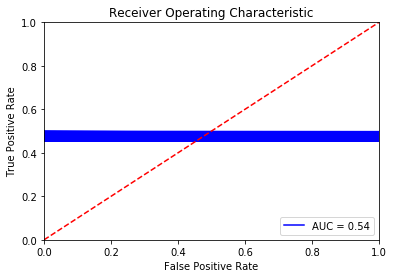

In [7]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(gt_list, pred_list, 'b', label = 'AUC = %0.2f' % roc_auc_score(gt_list,pred_list))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

(64, 64, 3) (64, 64) [[[0.5000028 ]
  [0.5000016 ]
  [0.49999774]
  ...
  [0.5000215 ]
  [0.500009  ]
  [0.5000194 ]]

 [[0.5000047 ]
  [0.50000423]
  [0.5000322 ]
  ...
  [0.5000143 ]
  [0.50000733]
  [0.5000147 ]]

 [[0.50000656]
  [0.50002843]
  [0.500038  ]
  ...
  [0.5000158 ]
  [0.50001097]
  [0.5000139 ]]

 ...

 [[0.5004939 ]
  [0.50038   ]
  [0.50037503]
  ...
  [0.5004871 ]
  [0.5002719 ]
  [0.5005996 ]]

 [[0.50020856]
  [0.50035834]
  [0.5002557 ]
  ...
  [0.50014305]
  [0.5003516 ]
  [0.500722  ]]

 [[0.50005823]
  [0.5001711 ]
  [0.5002436 ]
  ...
  [0.50025713]
  [0.50032604]
  [0.5003158 ]]]


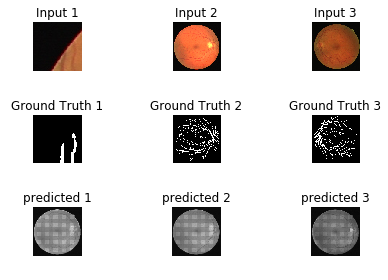

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
#from aug_utils import random_augmentation
from random import randint


def plot_figures(names, figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.
    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(names):
        img = np.squeeze(figures[title])
        if len(img.shape)==2:
            axeslist.ravel()[ind].imshow(img, cmap=plt.gray())#, cmap=plt.gray()
        else:
            axeslist.ravel()[ind].imshow(img)


        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

    plt.show()


def read_input(path):
    x = Image.open(path)
    return np.array(x)/255.


def read_gt(path):
    y = Image.open(path)
    return np.array(y)/255.


def random_crop(img, mask, crop_size=64):
    imgheight= img.shape[0]
    imgwidth = img.shape[1]
    i = randint(0, imgheight-crop_size)
    j = randint(0, imgwidth-crop_size)

    return img[i:(i+crop_size), j:(j+crop_size), :], mask[i:(i+crop_size), j:(j+crop_size)]

figures = {}
gt_1 = read_gt('gdrive/My Drive/DRIVE/test/1st_manual/01_manual1.gif')
img_1 = read_gt('gdrive/My Drive/DRIVE/test/images/01_test.tif')
pred_1 = (pred[0])
img_1, gt_1 = random_crop(img_1, gt_1, crop_size = 64)
print(img_1.shape, gt_1.shape, pred_1)
figures['Input 1'] = img_1
figures['Ground Truth 1'] = gt_1
figures['predicted 1'] = pred_1

gt_2 = read_gt('gdrive/My Drive/DRIVE/test/1st_manual/02_manual1.gif')
img_2 = read_gt('gdrive/My Drive/DRIVE/test/images/02_test.tif')
pred_2 = (pred[1])
figures['Input 2'] = img_2
figures['Ground Truth 2'] = gt_2
figures['predicted 2'] = pred_2

gt_3 = read_gt('gdrive/My Drive/DRIVE/test/1st_manual/03_manual1.gif')
img_3 = read_gt('gdrive/My Drive/DRIVE/test/images/03_test.tif')
pred_3 = (pred[2])
figures['Input 3'] = img_3
figures['Ground Truth 3'] = gt_3
figures['predicted 3'] = pred_3
#print(gt_3.shape)



# generation of a dictionary of (title, images)
names = ['Input 1', 'Input 2', 'Input 3', 'Ground Truth 1', 'Ground Truth 2', 'Ground Truth 3','predicted 1','predicted 2','predicted 3']

# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(names, figures, 3,3)